In [1]:

import astropy.units as u
import numpy as np
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from astropy.coordinates import SkyCoord, Distance
import popsims
import matplotlib.pyplot as plt
#%matplotlib notebook
from tqdm import tqdm
from astropy.constants import G
#import HSS
from gala.units import galactic
import gala.coordinates as gc
import  h5py
import imageio
import seaborn as sns
import matplotlib as mpl
import matplotlib.animation as animation
import astropy.coordinates as astro_coord
import glob
import pandas as pd
#sns.set_style("dark")
mpl.rc('xtick', labelsize=16) 
mpl.rc('ytick', labelsize=16) 
font = {'axes.titlesize'      : 'large',   # fontsize of the axes title
        'axes.labelsize'      : 'large', # fontsize of the x any y labels
        'size'   : 20}
import astropy.units as u
from astropy.io import ascii
import itertools
from scipy import stats
from shapey import Box
#paths
path_plot = '/users/caganze/research/stellarstreams/figures/paper/'
#path_data = '/users/caganze/research/stellarstreams/data/rotating/'
path_data = '/users/caganze/research/stellarstreams/data/stream/'
isochrone_path='/users/caganze/research/stellarstreams/data/isochrones/'


In [2]:
#coords standards
_ = astro_coord.galactocentric_frame_defaults.set('v4.0')

#potential and hamiltonian
pot=gp.MilkyWayPotential()
H = gp.Hamiltonian(pot)

#galactocentric reference frame
v_sun = astro_coord.CartesianDifferential([11.1, 220 + 24.0, 7.25]*u.km/u.s)

galcen_frame =astro_coord.Galactocentric(galcen_distance=8.*u.kpc,
                                    galcen_v_sun=v_sun)


#NSAMPLES_STREAM={27.15: 260, 28.54:1300}

In [3]:
#functions
def get_background(center, dist_range='10_20', dmod=25.0, FeH_phot=-1., mag_limit=27.15):
    
    #compute distance and scale Roman FOV
    d_M31=10**(dmod/5+1)*u.pc.to(u.kpc)
    kpc_conversion = np.pi * d_M31 / 180.
    scaled_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*(kpc_conversion /u.degree)
    print (kpc_conversion)
    
    
    outfile = isochrone_path+'/WFIfilters_extendedIsochrones_allbands_dmod{:.2f}_maglimit{}_M31_{}kpc.txt'.format(dmod,  mag_limit, dist_range)
    bckgd=ascii.read(outfile).to_pandas()
    bckgd=(bckgd[np.logical_and(bckgd.Z < mag_limit, bckgd.FeH_phot<FeH_phot)]).reset_index(drop=True)
    
    print (np.nanmedian(kpc_conversion*bckgd.RA.values))
    
    shift_x=np.nanmedian(kpc_conversion*bckgd.RA.values)-center[0]
    shift_y=np.nanmedian(kpc_conversion*bckgd.DEC.values)-center[1]
    
    bx_center=(center[-1], center[0])
    bx=roman_fov(center, scaled_fov.value, scaled_fov.value)
    bx.color='none'
    bx.edgecolor='r'
    df=pd.DataFrame()
    bckgd['x_coord']=kpc_conversion*bckgd.RA.values-shift_x
    bckgd['y_coord']=kpc_conversion*bckgd.DEC.values-shift_y
    
    return {'box': bx, 'data': bckgd.iloc[bx.select(bckgd[['x_coord', 'y_coord']]).index], 
           'arcmin':     scaled_arcmin, 'fov': scaled_fov}


def resample_stream(xy, mag_limit, d_mod, gap_center, center, box, rotate_by=None):
    
    key='mlimit{} dmod{:.2f}'.format(mag_limit, d_mod)
    N=int(round(NUM_STARS[key]))
    
    #crop [THIS IS CHEATING]
    
    x0=xy[0]-(gap_center[0]-center[0])
    y0=xy[1]-(gap_center[1]-center[1])
    
    #first rotate to 0 
    if rotate_by is not None: x0, y0= rotate(x0, y0, rotate_by, \
                                             c=(np.nanmedian(x0), np.nanmedian(y0)))

    
    choose=np.random.choice(np.arange(len(x0)), N)
    
    #rotate to horizontal
    
    selected=box.select(np.array([x0[choose], y0[choose]]))
    
    x=selected[0]
    y=selected[1]
    
    return  [x,  y]
                    
                    
        
def transform_to_phi_coordinates(st, end_points=None):
    stream_p=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.z.unit,
                          vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    #transform to stream coordinate frame 
    stream_c = stream_p.to_coord_frame(astro_coord.ICRS)
    
    if end_points is  None:
        min_ra_id= np.argmin(stream_c.ra.degree)
        max_ra_id=np.argmax(stream_c.ra.degree)
        
        end_points=astro_coord.SkyCoord(ra=[stream_c.ra.degree[min_ra_id], \
                                           stream_c.ra.degree[max_ra_id]]*u.deg,
                            dec=[stream_c.dec.degree[min_ra_id], \
                                           stream_c.dec.degree[max_ra_id]]*u.deg)

    fr = gc.GreatCircleICRSFrame.from_endpoints(end_points[0], end_points[1],
                                            ra0=np.nanmean(stream_c.ra))
    return {'icrs': stream_c, 'great_circ': stream_c.transform_to(fr)}

def roman_fov(center, xextent, yextent):
    b=Box()
    x_min, x_max =center[0]- xextent/2, center[0]+ xextent/2
    y_min, y_max =center[-1]- yextent/2, center[-1]+ yextent/2
    v1= (x_min, y_min)
    v2=(x_min, y_max)
    v4= (x_max, y_min)
    v3=(x_max,y_max)

    b.vertices=[v1, v2, v3, v4, v1]
    return b

#length and ith of the stream 
#procedure 
def compute_width(m, vc, Rgc):
    return Rgc*((m*G/(vc**2*Rgc))**(1/3))

def compute_physical_length(Rgc, m, vc, t):
    return  ((m*vc/Rgc)**(1/3))*t

def read_stream_file(filename):
    """
    reads in a saved stream run 
    returns the subhalo, progenitor and stream
    """
    print (filename)
    f = h5py.File(path_data+'/'+filename, mode='r')
    
    body=f['nbody']
    stream_cont=f['stream']
    
    #f.close()
    return body, stream_cont

def evolve_stream_in_time(st, time, dt=1*u.Myr, progenitor=False):
    time_dict={'t1': 0*u.Myr, 't2': time, 'dt': dt}
    #make a phase space position objec
    stpos=None
    if progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x.value, st.y.value, st.z.value])*st.x.unit,
                              vel=np.array([st.v_x.value, st.v_y.value, st.v_z.value])*st.v_z.unit)
    if not progenitor:
        stpos=gd.PhaseSpacePosition(pos=np.array([st.x, st.y, st.z])*st.x.unit,
                              vel=np.array([st.v_x, st.v_y, st.v_z])*st.v_z.unit)
    final_stream_orbit=gp.Hamiltonian(pot).integrate_orbit(stpos,  **time_dict)
    
    #integrate in time
    new_stream_coord=SkyCoord(x=final_stream_orbit.x[-1], y=final_stream_orbit.y[-1],
                       z= final_stream_orbit.z[-1], v_x=final_stream_orbit.v_x[-1],\
                       v_y=final_stream_orbit.v_y[-1], v_z=final_stream_orbit.v_z[-1],\
                       frame=galcen_frame)
    return new_stream_coord

def read_orbit_file(filename):
    return np.load(path_data+'/{}'.format(filename), allow_pickle=True)


def make_density_plot(values, ax, cmap=plt.cm.coolwarm, bins=100, hist=False):
    if not hist:
        kernel = stats.gaussian_kde(values)
        x, y=np.meshgrid(np.linspace(values[0].min()-0.9, values[0].max(), bins), \
                         np.linspace(values[1].min()-0.9, values[1].max(), bins))
        positions = np.vstack([x.ravel(), y.ravel()])
        Z = np.reshape(kernel(positions).T, x.shape)
        #ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r)
        ax.scatter(positions[0], positions[1], c=kernel(positions), cmap=cmap)
    if hist:
        _= ax.hist2d(values[0], values[1], cmap=cmap, bins=bins)
        
def rotate(x, y, ang, c=(0,0)):
    """
    Angle must be in radians
    """
    
    #rotation matrix
    r=[[np.cos(ang), -np.sin(ang)],
       [np.sin(ang), np.cos(ang)]]
    
    i=np.identity(2)
    
    mat=np.matrix([[r[0][0], r[0][1], np.dot(i-r, c)[0]],
                   [r[1][0], r[1][1], np.dot(i-r, c)[1]],
                   [0., 0., 1.]])

    z=np.ones_like(x)
    
    rotated=np.array(np.dot(mat, np.array([x, y, z])))
    
    return rotated[0], rotated[1] 

In [4]:
 
mhalo=5e6
dist='50_60'
mag_limit=28.54
ds=([0.5, 0.6, 0.77, 0.8, 0.9, 1.0, 1.3, 1.5, 1.6, 1.7, 2., 2.5, 3., 3.5, 4., 4.5, 5.])*u.Mpc
dmods=5*np.log10(ds.to(u.pc)/(10*u.pc)).value


NUM_STARS=pd.read_pickle(isochrone_path+'/number_of_stars_pal5.pkl')

In [5]:
STREAMS={'10_20': None, 
         '30_40': None,
        '50_60': None}


k= list(STREAMS.keys())[0]
#filename='mass_1_times_pal5_rgc10_mhalo1.00e+08_vhalo50_*'
#filename='test*'
#filename='rotating_Msub1.00e+06_ImpactVrz35*'
#filename='simpler_rgc10_direct_nbody1.00e+06*'
#stream
#%matplotlib notebook
k= list(STREAMS.keys())[0]
#filename='mass_1_times_pal5_rgc10_mhalo1.00e+08_vhalo50_*'
#filename='test*'
#filename='rotating_Msub1.00e+06_ImpactVrz35*'
#filename='simpler_rgc10_direct_nbody1.00e+06*'
#unpeturbed stream
filename='mass_1_times_pal5_rgc10_mhalo{:.2e}*_vhalo-50*'.format(mhalo)
f=path_data+'/{}.npy'.format(filename)
filenames=np.array(glob.glob(f))
st0=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0

#if False:
k= list(STREAMS.keys())[1]
#filename='mass_1_times_pal5_rgc30_mhalo1.00e+08_vhalo10_*'
#f=path_data+'/{}.npy'.format(filename)
#filenames=np.array(glob.glob(f))
#st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
STREAMS[k]= st0
#fig, ax=plt.subplots(figsize=(12, 4))
#ax.scatter(st.y, st.z, s=.1)

k= list(STREAMS.keys())[-1]
#filename='mass_1_times_pal5_rgc50_mhalo1.00e+08_vhalo10_*'
#f=path_data+'/{}.npy'.format(filename)
#filenames=np.array(glob.glob(f))
#st=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['stream']
#p=(read_orbit_file(filenames[0].split('/')[-1]).flatten()[0])['prog'][0]
STREAMS[k]= st0
#fig, ax=plt.subplots(figsize=(12, 4))
#ax.scatter(st.y, st.z, s=.1)
#ax.scatter(p.x, p.z, s=100)


In [6]:
#gap_center=(16, -41.5)
#gap_center=(0, 50)

In [7]:
#visualize gap in time steps
#for t in np.linspace(0.1, 5, 20):
#    evolved_st= evolve_stream_in_time(st, t*u.Gyr)
#    fig, ax=plt.subplots(figsize=(12, 4))
#    ax.scatter(evolved_st.y, evolved_st.z, s=1, alpha=0.1)
#    ax.set(title='Time {}'.format(t*u.Gyr+200*u.Myr))

In [8]:
images={}

for dmod in dmods:
    #get backgrounds
    rgc=np.nanmedian(np.array(dist.split('_')).astype(float))
    
    center=np.array([0, 0 ])+rgc
    
    vals=get_background(center, dist_range=dist, dmod=dmod, FeH_phot=-1., mag_limit=mag_limit)
    
    scaled_arcmin= vals['arcmin']
    
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    gap_center=(1, 7)
    
    
    evolved_st= STREAMS[dist]
    
    rst= resample_stream([st0.y.value, st0.x.value], \
                         mag_limit, dmod, (gap_center[0], gap_center[1]-0.5*(d_M31/0.77)), vals['box'].center,\
                         vals['box'], rotate_by=-np.pi/9)
    

    
    #append values to one image
    images.update({'{:.2f}'.format(dmod): [np.concatenate([vals['data'].x_coord,rst[0]]), \
                                           np.concatenate([vals['data'].y_coord,rst[1]])]})


8.726646259971647
41.3759801160518
10.471975511965983
49.68027831547767
13.439035240356349
63.68099600010795
13.962634015954642
66.15839831666105
15.707963267948978
74.44319603480756
17.453292519943293
82.80560438702763
22.689280275926293
107.51561895248845
26.179938779914952
124.04401010097149
27.92526803190929
132.46392924542891
29.670597283903614
140.79352572651175
34.90658503988659
165.546245707443
43.63323129985823
206.99238728719862
52.359877559829904
248.25069215034367
61.08652381980154
289.6038027388202
69.8131700797732
331.1430359557279
78.53981633974487
372.1602850702139
87.26646259971646
413.7440479809731


In [9]:
images.keys()

dict_keys(['23.49', '23.89', '24.43', '24.52', '24.77', '25.00', '25.57', '25.88', '26.02', '26.15', '26.51', '26.99', '27.39', '27.72', '28.01', '28.27', '28.49'])

In [10]:
fav_d=([0.5, 0.77, 1.0, 1.5, 2.0, 2.5 ])*u.Mpc
fav_dmods=5*np.log10(fav_d.to(u.pc)/(10*u.pc)).value

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_37966/3392910730.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(figname, rasterized=True)



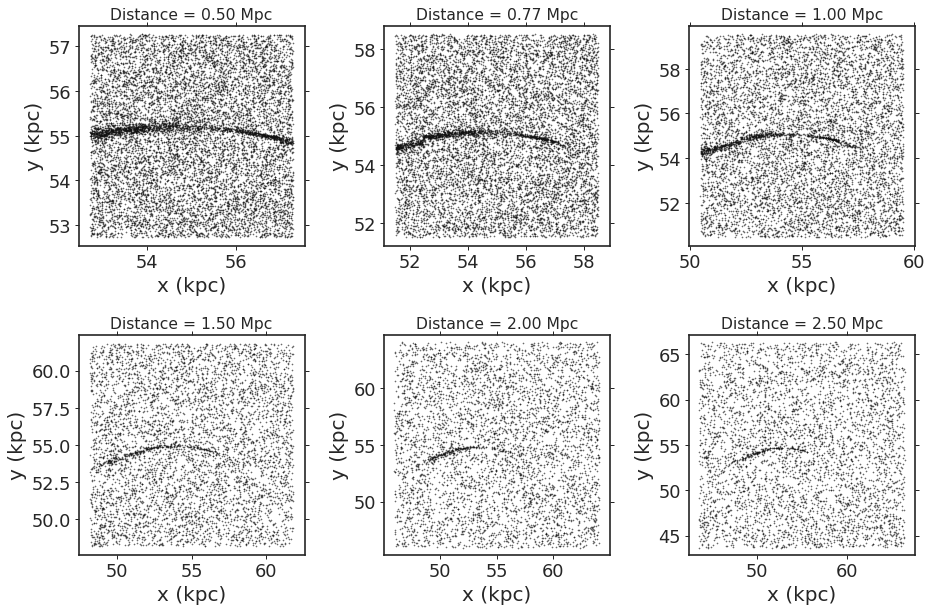

In [11]:
figname=path_plot+'/gaps_at_distance_mag{}mhalo{:.0e}rgc{}.jpeg'.format(mag_limit, mhalo, dist)

fig, ax=plt.subplots(figsize=(12, 4*2), ncols=3, nrows=2)
for dmod, a in zip(fav_dmods, np.concatenate(ax)):
    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    
    vals= images['{:.2f}'.format(dmod)]
    #print (vals)
    a.scatter(vals[0], vals[1], s=0.1, color='#111111')

    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)

    #b=vals['box']
    #b.alpha=1.
    #b.plot(ax=a)
    a.axis('equal')
    a.axis('equal')

    plt.tight_layout()

plt.savefig(figname, rasterized=True)

In [12]:
figname

'/users/caganze/research/stellarstreams/figures/paper//gaps_at_distance_mag28.54mhalo5e+06rgc50_60.jpeg'

In [13]:
#remake plots with only 

In [14]:
#save images
for k in images.keys():
    filename=path_data+'/gaps_at_OTHER{}Mhalo={:.2e}_maglimit{}.txt'.format(k, mhalo, mag_limit)
    data=images[k]
    #fig, ax=plt.subplots()
    #ax.scatter(data[0], data[1], s=1)
    #print (filename)
    pd.DataFrame(np.array(data).T, columns=['x', 'y']).to_csv(filename, index=False)

In [15]:
def make_a_cutout(key, size=None):
    
    data=np.vstack(images[key]).T
    #rotated= rotate(data[:,0], data[:,1], -np.pi/9)
    rotated=data.T
    
    center= np.nanmedian(rotated, axis=1)
    
    if size==None:
        #take a fraction of the range
        dy= np.nanmax(rotated[1])-np.nanmin(rotated[1])
        size=np.abs(0.2*dy)
    
    
    bx=roman_fov((center[0], center[1]), 5, size)
    selected= bx.select(pd.DataFrame(rotated ).T)
    
    #ax.scatter(selected.x, selected.y, s=1, color='#111111')
    
    return selected

In [16]:
len(images.keys())

17

In [17]:
cutouts={}
keys=list(images.keys())
for k in keys:
    filename=path_data+'/gaps_at_OTHER{}Mhalo={:.2e}_maglimit{}_cutout.txt'.format(k, mhalo, mag_limit)
    selected= make_a_cutout(k, size=1.5)
    selected.to_csv(filename, index=False)
    cutouts[k]= selected

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


8.726646259971647
13.439035240356349
17.453292519943293
26.179938779914952
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_37966/588950048.py:34: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "rasterized" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig(figname, rasterized=True)



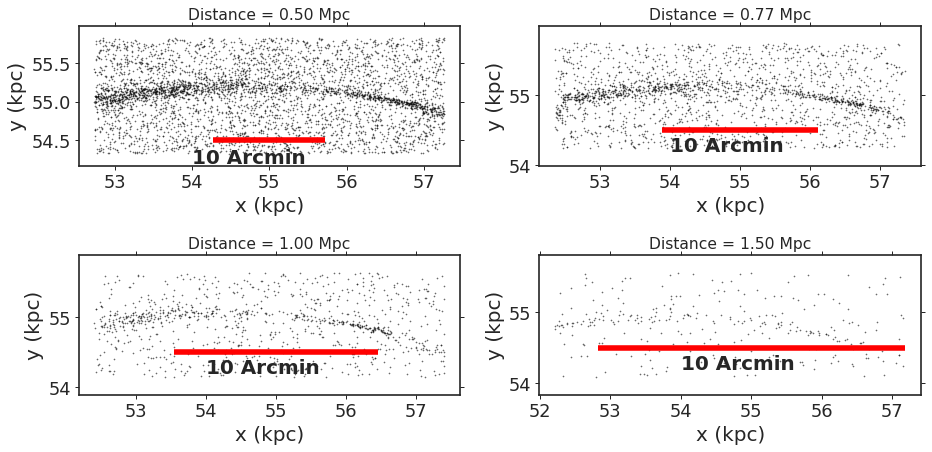

In [18]:
figname=path_plot+'/gaps_cutout_at_distance_mag{}mhalo{:.0e}rgc{}.jpeg'.format(mag_limit, mhalo, dist)

fig, ax=plt.subplots(figsize=(12, 4*1.5), ncols=2, nrows=2)
for dmod, a in zip(fav_dmods, np.concatenate(ax)):
    

    d_M31=10**(dmod/5+1)*u.pc.to(u.Mpc)
    d_M31kpc=10**(dmod/5+1)*u.pc.to(u.kpc)
    
    kpc_conversion = np.pi *  d_M31kpc / 180.
    print (kpc_conversion)
    scaled_arcmin= (10*u.arcmin.to(u.degree)*u.degree)*(kpc_conversion /u.degree)
    
    vals= cutouts['{:.2f}'.format(dmod)]
    #print (vals)
    a.scatter(vals.x, vals.y, s=0.1, color='#111111')

    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
    a.set_title(' Distance = {:.2f} Mpc '.format(  d_M31), fontsize=14)
    a.set_xlabel('x (kpc)', fontsize=18)
    a.set_ylabel('y (kpc)', fontsize=18)
    
    a.hlines(y=54.5, xmin=55-scaled_arcmin/2, xmax=55+scaled_arcmin/2, linewidth=5, color='r')
    a.text(54.0, 54.2, '10 Arcmin', weight='bold')

    #b=vals['box']
    #b.alpha=1.
    #b.plot(ax=a)
    a.axis('equal')


    plt.tight_layout()
    
plt.savefig(figname, rasterized=True)

In [19]:
figname

'/users/caganze/research/stellarstreams/figures/paper//gaps_cutout_at_distance_mag28.54mhalo5e+06rgc50_60.jpeg'